# Phase 4 AstroPi team Atlantes 2022-2023

## Introducción

En esta fase 4 del proyecto, dispondremos de los datos generados en la fase 3 por nuestro programa ejecutado en la Astro Pi VIS a bordo de la ISS.

Nuestro proyecto de este año se titula "El lenguaje de la Tierra". Utilizando datos de sensores y fotografías geolocalizadas tomadas por la ISS, crearemos una interfaz que señale los centros urbanos más importantes sobrevolados por la estación, y reproduzca diferentes audios en los diferentes idiomas utilizados en esos lugares. El experimento consiste en compilar los datos capturados por la ISS, contrastarlos con otras bases de datos y construir una interfaz de realidad aumentada (AR) para mostrar nuevos datos de imagen sobre las fotografías originales, junto con sonidos indígenas, significando el valor de un proyecto internacional como la ISS y dando voz a las diferentes culturas que comparten nuestro planeta.

## Preparando el entorno

Para que este cuaderno se ejecute correctamente hay que instalar unos paquetes en el sistema base. También necesitaremos los datos recopilados en la ISS y algunos ficheros auxiliares.

In [1]:
!pip install geopandas matplotlib jupyter opencv-python geopy exif numpy ffpyplayer
!wget https://niubit.net/media/uploads/images/atlantes_2022-2023/atlantes_files_for_colab.zip -O atlantes_files_for_colab.zip
!unzip -o -q atlantes_files_for_colab.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 137.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 107.7 MB/s eta 0:00:00
--2023-06-19 18:07:10--  https://niubit.net/media/uploads/images/atlantes_2022-2023/atlantes_files_for_colab.zip
Resolving niubit.net (niubit.net)... 167.86.121.85
Connecting to niubit.net (niubit.net)|167.86.121.85|:443... connected.
HTTP request sent, awai

La siguiente celda de código termina de preparar el entorno y define algunas variables.

In [2]:
%pylab inline
import os

# Adjusting chart dimensions
plt.rcParams["figure.figsize"] = (10, 8)                  # Size of charts in inches
plt.rcParams["figure.dpi"] = 90                           # Resolution of charts in DPIs

# Defining some environment variables for data sources
path = os.path.dirname(os.path.realpath("__file__"))
path_data = os.path.join(path, 'atlantes', 'data')
path_images = os.path.join(path, 'atlantes', 'images')

RESULTS_FILE = "atlantes.csv"                             # ESA CSV file

Populating the interactive namespace from numpy and matplotlib


# Órbita

El primer análisis que vamos a hacer como todos los años es el de la órbita seguida por la ISS durante nuestro experimento, para ayudarnos a identificar el terreno que aparece en las fotos.

<ipython-input-3-2d2ed216219a>:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


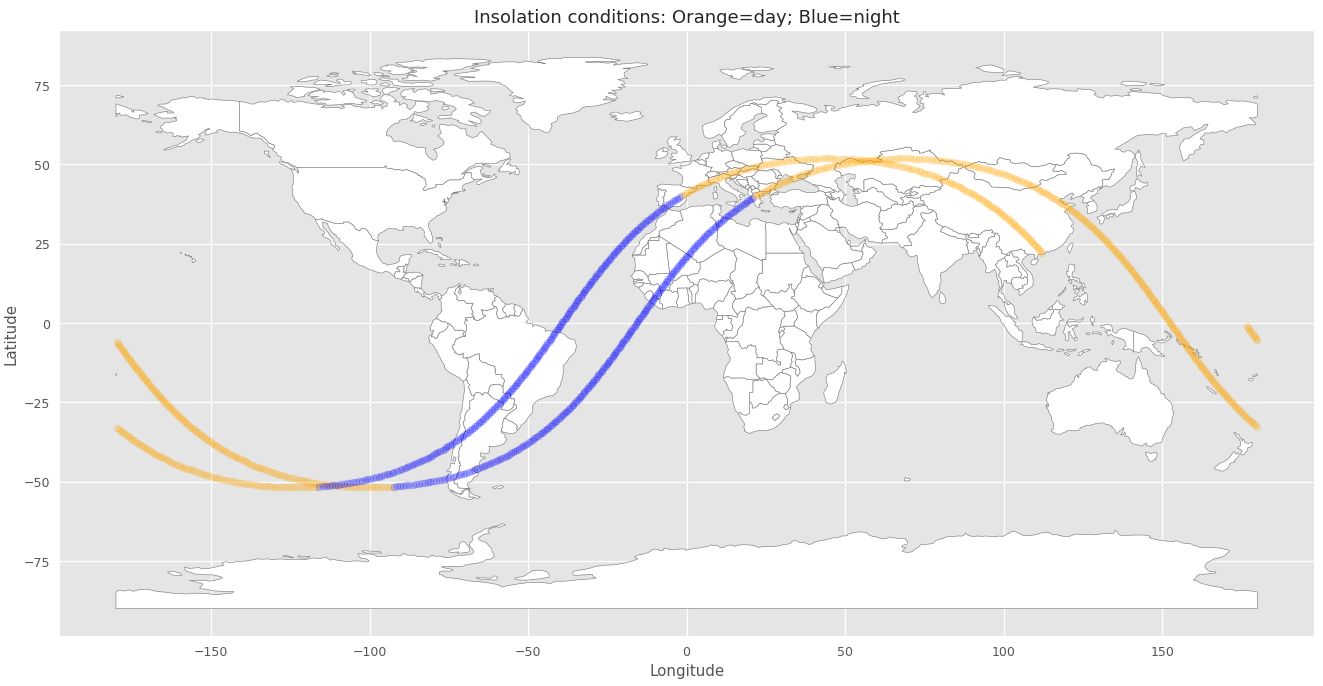

In [3]:
import os
import pandas
import matplotlib.pyplot as plt
import geopandas

file = os.path.join(path_data, RESULTS_FILE)      # CSV input file complete path

dataD1 = pandas.read_csv(file, nrows=145).tail(145)               # Day 1
dataN1 = pandas.read_csv(file, nrows=361).tail(216)               # Night 1
dataD2 = pandas.read_csv(file, nrows=702).tail(341)               # Day 2
dataN2 = pandas.read_csv(file, nrows=919).tail(217)               # Night 2
dataD3 = pandas.read_csv(file, nrows=1069).tail(150)              # Day 3

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

with plt.style.context(("seaborn", "ggplot")):
    world.plot(figsize=(18,10), color="white", edgecolor="grey")
    plt.scatter(dataD1.longitude, dataD1.latitude, zorder=1, alpha= 0.2, c='orange', s=30)
    plt.scatter(dataN1.longitude, dataN1.latitude, zorder=1, alpha= 0.2, c='blue', s=30)
    plt.scatter(dataD2.longitude, dataD2.latitude, zorder=1, alpha= 0.2, c='orange', s=30)
    plt.scatter(dataN2.longitude, dataN2.latitude, zorder=1, alpha= 0.2, c='blue', s=30)
    plt.scatter(dataD3.longitude, dataD3.latitude, zorder=1, alpha= 0.2, c='orange', s=30)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Insolation conditions: Orange=day; Blue=night")

# Orientación fotos

El primer problema que tenemos que resolver si queremos hacer un vídeo con las fotografías de AstroPi, es el de la corrección de la orientación de las mismas. AstroPi está colocada de forma que la cámara mira hacia la Tierra de forma lo más perpendicular posible, pero no es fácil conseguir orientarla de manera que el norte de la Tierra quede en la parte superior de las fotos para que éstas se correspondan bien con los mapas terrestres, además de que por la forma de la órbita esta orientación cambia continuamente. En realidad no cambia ya que la estación espacial no gira sobre sus ejes a no ser que haya una corrección de la órbita u orientación, pero al utilizar una órbita no ecuatorial, la inclinación aparente de las fotos cambia continuamente como luego veremos.

> Dado que tardamos en recibir los datos de AstroPi, empezamos haciendo este análisis con fotos y datos del proyecto del año pasado. Como al final llegamos a conseguir automatizar los cálculos con un algoritmo, lo aplicaremos más adelante sobre los datos de 2022-2023, pero hasta que no se indique otra cosa, los siguientes análisis se han hecho con datos correspondientes a 2021-2022.

Vamos a calcular la orientación de las fotografías tomadas por AstroPi para girarlas de forma que queden con la misma orientación de los mapas (norte arriba). Utilizaremos como ejemplo los datos de las fotos 493 y 494 del proyecto del año 2021-2022 que corresponden al sobrevuelo de Pamplona.

|Fóto #|Fecha|Archivo foto|Latitud|Longitud|Altitud|
|:-----|:----|:-----------|:------|:-------|:------|
|493|2022-04-26 10:14:03,314|atlantes_493.jpg|43,097612303689|-2,3949488058073|420980,867804757|
|494|2022-04-26 10:14:18,314|atlantes_494.jpg|42,5769655132425|-1,34409030873256|420935,392917282|

Necesitamos calcular dos ángulos:

* α: Ángulo respecto al ecuador de la línea que une los puntos de las coordenadas (latitud, longitud) asociadas a cada foto, que en principio debería coincidir con el punto central de la foto (luego veremos que en realidad no es así). Este ángulo cambiará continuamente entre foto y foto por la inclinación de la órbita.
* β: Ángulo de la línea que representa el desplazamiento aparente de un objeto referencia (por ejemplo una nube pequeña o un cabo de la costa) entre dos fotos consecutivas. Este ángulo se mantendrá constante siempre que no haya cambio en la orientación de la estación respecto a la Tierra.

El ángulo α podemos representarlo así:

![Ángulo alfa](https://niubit.net/media/uploads/images/atlantes_2022-2023/alpha.png)

Para determinar el ángulo necesitamos conocer las dimensiones del triángulo anterior. En el gráfico ya hemos colocado las distancias que vamos a calcular ahora. El cálculo lo haremos a partir de la latitud y longitud de las fotografías, que como hemos comentado antes coincidirá aproximadamente con el centro de las imágenes.

El cálculo de las distancias lo hacemos con el siguiente bloque de código. La distancia entre 493 y 494 no coincide con la que resultaría de aplicar el teorema de Pitágoras a los catetos del triángulo rectángulo anterior, porque en realidad las tres distancias son curvas que siguen la superficie de la Tierra (la curva se llama [Ortodrómica](https://es.wikipedia.org/wiki/Ortodr%C3%B3mica) o [Great-circle distance](https://en.wikipedia.org/wiki/Great-circle_distance) en inglés).

In [4]:
# https://www.cosmoscalibur.com/blog/calcular-distancia-geodesica-con-python/
# https://geopy.readthedocs.io/en/latest/#module-geopy.distance
from geopy import distance

pnt_493 = (43.097612303689, -2.3949488058073)
pnt_494 = (42.5769655132425, -1.34409030873256)
pnt_X = (43.097612303689, -1.34409030873256)

print(distance.great_circle(pnt_493, pnt_494).m)
print(distance.great_circle(pnt_493, pnt_X).m)
print(distance.great_circle(pnt_X, pnt_494).m)

103408.22860916496
85322.4488809735
57893.363454430306


Con las distancias horizontal y vertical podemos calcular α con la función arcotangente de la siguiente forma:

$$
\alpha = \arctan{\left(\frac{-57893.363454430306}{85322.4488809735}\right)}
$$

Utilizamos la función [math.atan2()](https://docs.python.org/3/library/math.html#math.atan2) de Python para obtener la arcotangente:

In [5]:
import math

delta_rad = math.atan2(-57893.363454430306, 85322.4488809735)
delta_deg = math.degrees(delta_rad)
print(delta_deg)

-34.15784952082556


Por tanto:

$$
\alpha = \arctan{\left(\frac{-57893.363454430306}{85322.4488809735}\right)} = -34,16º
$$

Para el ángulo β usaremos algún elemento reconocible en las dos fotos consecutivas, cuanto más cerca del centro de las fotos mejor para evitar deformaciones de perspectiva. Por ejemplo:

![493](https://niubit.net/media/uploads/images/atlantes_2022-2023/atlantes_493_crosshair.jpg)
![494](https://niubit.net/media/uploads/images/atlantes_2022-2023/atlantes_494_crosshair.jpg)

Superponiendo las dos fotografías podemos ver el desplazamiento del punto elegido y por tanto podremos estimar tanto la distancia recorrida como el ángulo.

![494-493](https://niubit.net/media/uploads/images/atlantes_2022-2023/atlantes_493_494_line.jpg)

El desplazamiento en píxeles entre los dos puntos es: 633 en horizontal hacia la derecha y 77 en vertical hacia abajo. El ángulo β se puede calcular de nuevo con la función arcotangente aplicada al cociente de las dos distancias:

$$
\beta = \arctan{\left(\frac{-77}{633}\right)} = -6,94º
$$

Ya era muy evidente analizando las fotos, que éstas están giradas casi 180º, es decir que la parte de arriba mira casi directamente hacia el sur. Si la cámara de la AstroPi hubiera estado perfectamente alineada con el eje de la Tierra (dejando arriba el norte), ambos ángulos α y β tendrían una diferencia entre ellos de 180º, ya que si la ISS avanza por ejemplo hacia el este en horizontal, lo que vemos en las fotos debería desplazarse hacia el oeste. Así pues, podemos obtener el ángulo de giro de la AstroPi respecto al norte, y por tanto el ángulo que deberemos girar en sentido contrario las fotos para orientarlas correctamente, por medio de la siguiente fórmula:

$$
\gamma = \alpha - \beta + 180 = (-34,16) - (-6,94) + 180 = 152,78º
$$

Rotando la foto 493 152,78º en el sentido contrario de las agujas del reloj vemos que efectivamente hace coincidir el perfil de la costa con lo que vemos en los mapas:

![493 girada](https://niubit.net/media/uploads/images/atlantes_2022-2023/atlantes_493_girada.jpg)

![493 mapa](https://niubit.net/media/uploads/images/atlantes_2022-2023/493_mapa.png)

Haciendo los mismos cálculos sobre una fotografía muy alejada de la anterior (utilizamos una del Golfo de San Lorenzo en Canadá) encontramos que la orientación de las fotos varía durante la órbita, lo que nos obliga a calcularla foto a foto, por lo que tendremos que encontrar la forma de automatizar el cálculo, sobre todo el del ángulo β que se determina gráficamente. Como hemos comentando ya, este ángulo debería ser constante, por lo que calcularemos su valor entre todas las parejas de fotos (una foto y la siguiente) y luego haremos la media. Vamos a utilizar la mediana en lugar de la media ya que el sistema para calcular el desplazamiento en píxeles entre dos fotografías produce numerosos valores atípicos. Con la mediana conseguimos deshacernos de esos valores atípicos.

El cálculo de β lo vamos a hacer ya con los datos/fotos de 2022-2023. En concreto sobre el intervalo de fotos 950 a 1069. Lo hacemos con el siguiente bloque de código:

In [6]:
import os
import cv2
import math
import statistics

PHOTO_START = 950
PHOTO_END = 1069

path = os.path.dirname(os.path.realpath("__file__"))
path_data = os.path.join(path, 'atlantes', 'data')
path_images = os.path.join(path, 'atlantes', 'images')

def calculate_features(image_1_cv, image_2_cv, feature_number):
    orb = cv2.ORB_create(nfeatures = feature_number)
    keypoints_1, descriptors_1 = orb.detectAndCompute(image_1_cv, None)
    keypoints_2, descriptors_2 = orb.detectAndCompute(image_2_cv, None)
    return keypoints_1, keypoints_2, descriptors_1, descriptors_2

def calculate_matches(descriptors_1, descriptors_2):
    brute_force = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = brute_force.match(descriptors_1, descriptors_2)
    matches = sorted(matches, key=lambda x: x.distance)
    return matches

def display_matches(image_1_cv, keypoints_1, image_2_cv, keypoints_2, matches):
    match_img = cv2.drawMatches(image_1_cv, keypoints_1, image_2_cv, keypoints_2, matches[:10], None)
    resize = cv2.resize(match_img, (1600,600), interpolation = cv2.INTER_AREA)
    cv2.imshow('matches', resize)
    cv2.waitKey(0)
    cv2.destroyWindow('matches')

def find_matching_coordinates(keypoints_1, keypoints_2, matches):
    coordinates_1 = []
    coordinates_2 = []
    for match in matches:
        image_1_idx = match.queryIdx
        image_2_idx = match.trainIdx
        (x1,y1) = keypoints_1[image_1_idx].pt
        (x2,y2) = keypoints_2[image_2_idx].pt
        coordinates_1.append((x1,y1))
        coordinates_2.append((x2,y2))
    return coordinates_1, coordinates_2

beta_list = list()
for i in range(PHOTO_START, PHOTO_END):
    photo_a = os.path.join(path_images, "atlantes_%d.jpg" % (i))
    photo_b = os.path.join(path_images, "atlantes_%d.jpg" % (i+1))
    photo_a_cv = cv2.imread(photo_a, 0)
    photo_b_cv = cv2.imread(photo_b, 0)
    keypoints_a, keypoints_b, descriptors_a, descriptors_b = calculate_features(photo_a_cv, photo_b_cv, 1000)
    matches = calculate_matches(descriptors_a, descriptors_b)
    coordinates_a, coordinates_b = find_matching_coordinates(keypoints_a, keypoints_b, matches)
    beta_matches_list = list()
    for ca, cb in zip(coordinates_a, coordinates_b):
        dx = round(cb[0] - ca[0])
        dy = round(cb[1] - ca[1])
        beta_rad = math.atan2(-dy, dx)
        beta_deg = math.degrees(beta_rad)
        beta_matches_list.append(beta_deg)
        #print(f"H: {dx}; V: {dy}; β: {beta_deg}")
    #print(f"beta{i}_mediana: {statistics.median(beta_matches_list)}")
    beta_list.append(statistics.median(beta_matches_list))
beta = statistics.median(beta_list)
print(f"β = {beta}")

β = -92.63402610900921


Obtenemos pues el siguiente valor:

$$
\beta = -92,63º
$$

Como sabemos, debemos rotar las fotos un ángulo γ que se calcula así:

$$
\gamma = \alpha - \beta + 180 = \alpha + 272,63
$$

α variará entre foto y foto, por lo que lo determinaremos dinámicamente por código y aprovecharemos el mismo bucle para rotas las fotos. También vamos a almacenar en una estructura de datos los valores de α calculados para cada foto, puesto que nos hará falta a partir de ahora para casi cada operación que vayamos a hacer sobre las fotos. En realidad lo que más necesitaremos es el ángulo γ, pero puesto que se puede deducir directamente a partir de α nos quedamos solo con este último.

Además de girar las fotos las vamos a recortar para hacer cuadradas, dado que el formato original 4:3 hace que aparezcan bandas negras por los lados, fundamentalmente por izquierda y derecha, que se minimizan en parte al pasar a formato 1:1.

In [7]:
import os
import cv2
import numpy as np
import math
import exif
import json
from geopy import distance


def dms2dec(dms, ref):
    return (dms[0] + dms[1] / 60. + dms[2] / 3600.) * (1 if ref in ('N', 'E') else -1)

def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def crop_image(image):
    # Dimensiones de la imagen original
    height, width = image.shape[:2]

    # Tamaño deseado para la imagen recortada
    crop_size = min(height, width)

    # Coordenadas del punto de inicio para recortar la imagen original
    start_x = (width - crop_size) // 2
    start_y = (height - crop_size) // 2

    # Recorte de la imagen original
    cropped_image = image[start_y:start_y+crop_size, start_x:start_x+crop_size]

    return cropped_image


PHOTO_START = 950
PHOTO_END = 1069

path = os.path.dirname(os.path.realpath("__file__"))
path_data = os.path.join(path, 'atlantes', 'data')
path_images = os.path.join(path, 'atlantes', 'images')
path_images_rot = os.path.join(path, 'atlantes', 'images_rotated')

beta = -92.63402610900921

if not os.path.exists(path_images_rot):
    os.makedirs(path_images_rot)

alphas = {}

for i in range(PHOTO_START, PHOTO_END):
    photo_a_path = os.path.join(path_images, "atlantes_%d.jpg" % (i))
    photo_b_path = os.path.join(path_images, "atlantes_%d.jpg" % (i+1))
    photo_a_file = open(photo_a_path, 'rb')
    photo_b_file = open(photo_b_path, 'rb')
    img_a = exif.Image(photo_a_file)
    img_b = exif.Image(photo_b_file)
    pnt_a = (dms2dec(img_a.get('gps_latitude'), img_a.get('gps_latitude_ref')), dms2dec(img_a.get('gps_longitude'), img_a.get('gps_longitude_ref')))
    pnt_b = (dms2dec(img_b.get('gps_latitude'), img_b.get('gps_latitude_ref')), dms2dec(img_b.get('gps_longitude'), img_b.get('gps_longitude_ref')))
    pnt_X = (pnt_a[0], pnt_b[1])
    dx = distance.great_circle(pnt_a, pnt_X).km * (1 if pnt_b[1] > pnt_a[1] else -1)
    dy = distance.great_circle(pnt_X, pnt_b).km * (1 if pnt_b[0] > pnt_a[0] else -1)
    alpha_rad = math.atan2(dy, dx)
    alpha_deg = math.degrees(alpha_rad)
    gamma = alpha_deg - beta + 180

    photo_cv = cv2.imread(photo_a_path, cv2.IMREAD_UNCHANGED)
    photo_rot_cv = rotate_image(photo_cv, gamma)
    photo_rot_crop_cv = crop_image(photo_rot_cv)
    photo_rot = os.path.join(path_images_rot, "atlantes_%d.jpg" % (i))
    cv2.imwrite(photo_rot, photo_rot_crop_cv)
    alphas[i] = alpha_deg

    photo_a_file.close()
    photo_b_file.close()

# Rotamos la última foto con el último ángulo calculado, ya que no tenemos la foto siguiente para
# hacer el cálculo con precisón.
photo_cv = cv2.imread(photo_b_path, cv2.IMREAD_UNCHANGED)
photo_rot_cv = rotate_image(photo_cv, gamma)
photo_rot_crop_cv = crop_image(photo_rot_cv)
photo_rot = os.path.join(path_images_rot, "atlantes_%d.jpg" % (PHOTO_END))
cv2.imwrite(photo_rot, photo_rot_crop_cv)
alphas[PHOTO_END] = alpha_deg

# Guardamos los alphas calculados para utilizarlos más adelante.
json_object = json.dumps(alphas, indent = 4)
with open(os.path.join(path, "alphas_%d-%d.json" % (PHOTO_START, PHOTO_END)), "w") as text_file:
    text_file.write(json_object)

# Georreferencia fotos

## Introducción

Ya tenemos las fotos correctamente orientadas. Lo siguiente que necesitamos es georreferenciar o posicionar correctamente en coordenadas terrestres (latitud, longitud) los píxeles de las fotos de manera que podamos añadir marcas sobre ellas para por ejemplo señalar ciudades.

El programa ejecutado en AstroPi ya nos proporciona directamente las coordenadas del punto central de cada foto, aunque como luego veremos, en realidad esas coordenadas incluyen un error sistemático al no estar la cámara perfectamente orientada al centro de la Tierra.

A partir de ese punto central de las fotos (convenientemente corregido) y calculando las dimensiones de los píxeles en distancia sobre la superficie de la Tierra a partir de las características de la óptica y de la altitud de la estación espacial, podremos por fin georreferenciar cada pixel de la foto.

## Resolución de las fotos

Lo primero que necesitamos es conocer el factor pixel/m de las fotos, es decir averiguar las dimensiones de las fotos en metros. Esto depende de las características de la óptica de la cámara de AstroPi y de la altura de la estación. [Esta web](https://www.3dflow.net/ground-sampling-distance-calculator/) nos ayuda a calcularlo. Por ejemplo para la foto 1023, los parámetros son los siguientes:

* Image width (pixels): 3280
* Image height (pixels): 2464
* Focal lenght (mm): 5
* Sensor width (mm): 6.287
* Distance (d) in meters: 421522.31

![Ground sampling distance calculator](https://niubit.net/media/uploads/images/atlantes_2022-2023/Ground_sampling_distance_calculator2.png)

Como vemos el resultado es:

* GSD (cm/pixel): 16159.212
* Dw (m): 530022.153
* Dh (m): 398162.983

Necesitamos saber si el GSD obtenido será válido para todas las fotos. En los cálculos, el único dato que puede variar entre foto y foto es d es decir la altitud de la estación. Representando dicha altitud con el tiempo vemos que sí varía:

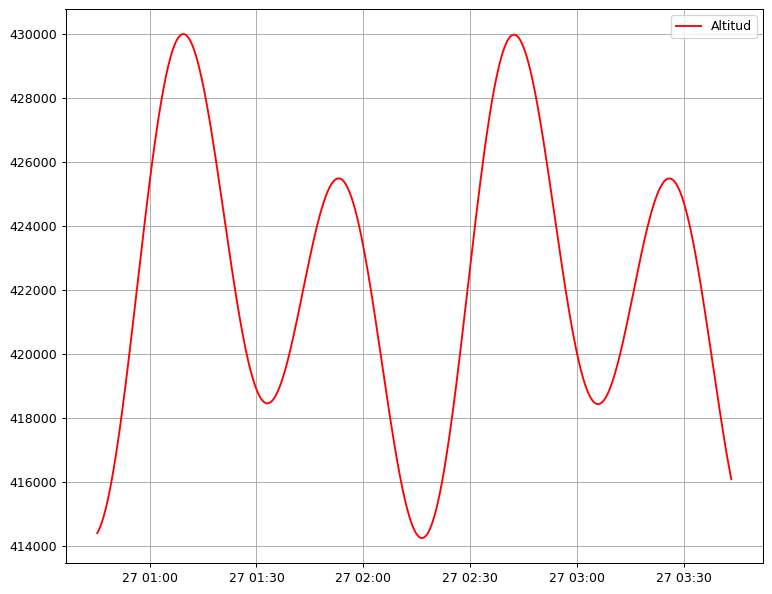

In [8]:
import os
import pandas
import matplotlib.pyplot as plt

# Defining some environment variables for data sources
path = os.path.dirname(os.path.realpath("__file__"))
path_data = os.path.join(path, 'atlantes', 'data')
RESULTS_FILE = "atlantes.csv"

file = os.path.join(path_data, RESULTS_FILE)  # CSV input file complete path
data = pandas.read_csv(file, parse_dates=[0]) # Reading whole file

# Columns in file:
#    "datetime", "picture_file", "latitude", "longitude", "elevation", "temp_cpu", "temp_h", "temp_p",
#    "humidity", "pressure", "pitch", "roll", "yaw", "mag_x", "mag_y", "mag_z",
#    "accel_x", "accel_y", "accel_z", "gyro_x", "gyro_y", "gyro_z"
data_x = data.datetime
data_y = data.elevation

fig, ax = plt.subplots()
ax.plot(data_x, data_y, label="Altitud", color="red")

plt.legend()                                  # Activating chart legend
plt.grid()                                    # Activating chart grid
plt.show()                                    # Showing the chart

Por tanto tenemos que aprender a hacer los cálculos que se hacen en la [web](https://www.3dflow.net/ground-sampling-distance-calculator/) que habíamos utilizado. El cálculo es una simple regla de tres:

$$
D_w = \frac{S_w * d}{F}
$$

Y el factor de conversión pixels/distancia se obtiene fácilmente dividiendo por la resolución de las fotos y convirtiendo los metros en centímetros:

$$
GSD = \frac{D_w * 100}{\textrm{Image width}} = \frac{S_w * d * 100}{F * \textrm{Image width}}
$$

Por ejemplo, el cálculo que habíamos hecho en la [web](https://www.3dflow.net/ground-sampling-distance-calculator/) se puede reproducir así:

$$
GSD = \frac{S_w * d * 100}{F * \textrm{Image width}} = \frac{6,287 * 421522,31 * 100}{5 * 3280} = 16159,212\;cm/px
$$

Las fotos tienen todas una resolución de 3280px de ancho y 2464px de alto. Por tanto la foto 1023 de la que hemos hecho os cálculos cubrirá las siguientes distancias en horizontal y vertical:

$$
D_w =  \frac{\textrm{Image width} * GSD}{100 cm/m} = \frac{3280 * 16159,212}{100} = 529341 m = 530,02 km
$$
$$
D_h =  \frac{\textrm{Image height} * GSD}{100 cm/m} = \frac{2464 * 16159,212}{100} = 397652 m = 398,16 km
$$

Como al rotar las fotos aparecen franjas negras sobre todo por los lados izquierdo/derecho, además de rotarlas en el proceso aplicado al final del apartado **Orientación fotos** las hemos recortado para que tengan un formato cuadrado, minimizando los bordes negros. Por tanto en las fotos finales la distancia horizontal y vertical que cubren es la misma y concretamente la mínima de la dos anteriores:

$$
D = 397652 m = 398,16 km
$$

## Corrección posición centro cámara

Otro efecto que hemos observado en las fotos es que lo que aparece en el centro no coincide con las coordenadas (latitud, longitud) asociadas a la foto. Esto es normal dado que los astronautas que colocan la AstroPi al empezar la captura de los datos no cuentan con un sistema de calibración que asegure que el eje de la cámara esté correctamente dirigido al centro de la Tierra. Así pues vamos a calcular la desviación para corregirla en nuestros cálculos posteriores. Será fundamental para superponer correctamente cualquier elemento como por ejemplo ciudades sobre las fotos.

Para ello elegiremos una foto que contenga exactamente en el centro un objeto fácilmente reconocible del terreno que nos permita relacionar sus coordenadas reales con las asociadas a la foto. La foto elegida es la 1011 que muestra el lago Balkhash en Kazzajistán:

![1011](https://niubit.net/media/uploads/images/atlantes_2022-2023/atlantes_1011_crosshair.jpg)

La posición de la foto capturada por el programa ejecutado en AstroPi y que teóricamente corresponde al punto central (que vemos marcado en la foto anterior) es (a este punto lo llamaremos I):

* Latitud: 45.916122
* Longitud: 78.825319

Localizamos ese punto central en un mapa real:

![1011 real](https://niubit.net/media/uploads/images/atlantes_2022-2023/atlantes_1011_real.png)

Vemos que las coordenadas del punto central en realidad son (a este punto lo llamaremos O):

* Latitud: 46.456680
* Longitud: 78.312938

Vamos a suponer que el desplazamiento se mantiene constante en todas las fotos, por lo que deduciéndolo de la foto anterior nos servirá para corregirlas todas. Lo que vamos a calcular es la magnitud y el ángulo de la corrección que tendremos que efectuar a las coordenadas del punto central de cada foto. El problema es que el ángulo será constante en la orientación original de las fotos, pero sobre las fotos ya rotadas tendremos que tener en cuenta dicha rotación. No podemos trabajar con las fotos antes de la rotación ya que la librería [geopy](https://geopy.readthedocs.io/en/latest) que utilizamos para los cálculos solo puede trabajar con fotos/mapas correctamente orientadas, es decir con el norte arriba. Empezamos pues haciendo los cálculos de la magnitud de la desviación y su ángulo. Vamos a utilizar el típico triángulo rectángulo que utilizamos durante la orientación de las fotos para determinar distancia y ángulo entre dos puntos latitud/longitud.

En la foto siguiente vemos representados el punto que corresponde a la posición de la foto medida por AstroPi (I) y el de la posición central de la misma (O).

![1011 error](https://niubit.net/media/uploads/images/atlantes_2022-2023/atlantes_1011_crosshair_error.jpg)

Como vemos el error no es pequeño por lo que hay que tenerlo en cuenta o la representación de elementos sobre las fotos resultará demasiado imprecisa. Las coordenadas de los puntos I y O son las que hemos comentado antes, es decir:

* I: 45.916122, 78.825319
* O: 46.456680, 78.312938

Con estas coordenadas empezamos haciendo el mismo análisis de triangulación que hicimos para determinar el ángulo 𝛼:

In [9]:
# https://www.cosmoscalibur.com/blog/calcular-distancia-geodesica-con-python/
# https://geopy.readthedocs.io/en/latest/#module-geopy.distance
from geopy import distance

pnt_I = (45.916122, 78.825319)
pnt_O = (46.456680, 78.312938)
pnt_X = (46.456680, 78.825319)

print(distance.great_circle(pnt_I, pnt_O).m)
print(distance.great_circle(pnt_I, pnt_X).m)
print(distance.great_circle(pnt_X, pnt_O).m)

71893.53753199767
60107.39206778084
39249.6513881173


El esquema que nos ayudará a determinar la magnitud y el ángulo del error es el siguiente:

![delta](https://niubit.net/media/uploads/images/atlantes_2022-2023/delta_1011.png)

Con las distancias horizontal y vertical podemos calcular δ con la función arcotangente de la siguiente forma:

$$
\delta = \arctan{\left(\frac{60107.39206778084}{-39249.6513881173}\right)}
$$

Utilizamos la función [math.atan2()](https://docs.python.org/3/library/math.html#math.atan2) de Python para obtener la arcotangente:

In [10]:
import math

delta_rad = math.atan2(60107.39206778084, -39249.6513881173)
delta_deg = math.degrees(delta_rad)
print(delta_deg)

123.14421879429942


Por tanto:

$$
\delta = \arctan{\left(\frac{60107.39206778084}{-39249.6513881173}\right)} = 123.14º
$$

Así pues, para encontrar las coordenadas de O a partir de las de I, tenemos que desplazarnos 71894m con el ángulo δ que acabamos de calcular.

Como hemos comentado antes, el ángulo δ a utilizar dependerá de la rotación que hayamos aplicado a la foto (𝛾) que a su vez depende de la inclinación de la órbita respecto del ecuador (α). A partir de un caso particular como el anterior podremos obtener el δ de cualquier foto estableciendo diferencias relativas con el 𝛾 de ambas fotos de la siguiente manera:

$$
\delta_1 = \delta_0 - \gamma_0 + \gamma_1
$$

$$
\delta = 123.14 - 243.75 + \gamma = \gamma - 120.61 = \alpha + 272.63 - 120.61 = \alpha + 152.02
$$

Resumiendo, la corrección general que como hemos comentado es dependiente de 𝛾, será:

* Magnitud: 71894m
* Ángulo: $\delta = \gamma - 120.61 = \alpha + 152.02$

La corrección podemos hacerla con la función [`destination()`](https://geopy.readthedocs.io/en/latest/#geopy.distance.Distance.destination) de geopy. Hay que tener en cuenta que el ángulo introducido en el argumento `bearing` de esta función está orientado de otra forma. El norte se indica con 0º y el sentido de giro es el de las agujas del reloj, mientras que el δ que nosotros estamos manejando tiene su valor 0º en el este y el sentido de giro es el contrario al de las agujas del reloj. La relación entre ambos es:

$$
bearing = 90 - \delta
$$

Por ejemplo para la foto 1023 la corrección de las coordenadas del punto central de la foto se haría en base a los siguientes datos:

* Posición medida por AstroPi: $I = (41.976585,87.592487)$
* Ángulo de inclinación de la órbita: $\alpha = -35.65º$
* Distancia de la corrección: $71894m$
* Ángulo de la corrección: $\delta = \alpha + 152.02 = 116.37º$
* Ángulo para la función `destination()`: $bearing = 90 - \delta = 90 - \alpha - 152.02 = -62.02 - \alpha  = -26.37º$

se haría así:

In [11]:
from geopy import distance

distance.great_circle(meters=71894).destination((41.976585,87.592487), bearing=-26.37)

Point(42.5552085799654, 87.2026351716313, 0.0)

Como vemos, la posición corregida del punto central de la foto es: $O = (42.555209, 87.202635)$

Habiendo dominado la geometría del problema, nos planteamos ahora, las conversiones que tenemos que hacer en uno y otro sentido entre píxeles y coordenadas que vamos a necesitar más adelante. Estudiamos a continuación los dos tipos de conversiones que nos vamos a plantear.

## Conversión pixels a coordenadas

En este caso, lo que perseguimos es conocer las coordenadas (latitud,longitud) de un pixel (X,Y) de cualquiera de las fotos. Esto por ejemplo lo utilizaremos para determinar los bordes de las fotos de manera que podamos hacer búsquedas de objetos interesantes que representar dentro de las mismas (por ejemplo las poblaciones con más de 100.000 habitantes que caen en una foto).

Vamos a hacer la aproximación de que la fotografía tiene la misma geometría cuadrada que tienen los mapas, es decir que los lados izquierdo y derecho son rectos y correspondientes a una longitud definida. En una foto real los meridianos que discurren por los bordes laterales son curvos (como los veríamos en una bola del mundo). Al contrario, los paralelos de los bordes superior e inferior son, como su nombre indica paralelos al ecuador y por tanto rectos, por lo que no se produce distorsión (en realidad sí hay una distorsión por la perspectiva, pero despreciaremos este efecto). La aproximación de los bordes laterales es tanto mejor cuanto más cerca estemos del ecuador. En los polos la aproximación es más problemática, pero afortunadamente la ISS no supera la latitud 51,64º, por lo que podemos aceptar esta situación.

Para obtener las coordenadas (latitud,longitud) de cualquier punto, podremos usar la función [`destination()`](https://geopy.readthedocs.io/en/latest/#geopy.distance.Distance.destination) vista antes. Como sabemos, tenemos que indicar la distancia a recorrer desde una posición determinada (utilizaremos el punto central de la foto que es el único que tenemos localizado inicialmente) y el ángulo de avance. La distancia a recorrer la podremos calcular gracias al valor de GSD de la foto (recordar que depende de la altitud a que fue tomada la foto). El ángulo lo determinaremos en base a la diferencia en horizontal y vertical en píxeles desde el centro de la foto al pixel deseado. Con estas ideas vamos a determinar las latitudes inferior y superior de las fotos y las longitudes izquierda y derecha. Una vez conocido ese rango de latitudes y longitudes, podremos calcular las coordenadas de cada pixel haciendo una conversión lineal, que de nuevo es una aproximación, pero que estimamos funcionará razonablemente bien.

De nuevo vamos a utilizar como ejemplo la foto 1023. En la siguiente representación vemos los puntos que queremos calcular:

![1023 borde](https://niubit.net/media/uploads/images/atlantes_2022-2023/atlantes_1023_border.jpg)

Recordamos que la resolución de las fotos es 2464x2464 y el GSD obtenido para esta fotografía (recordamos que depende de la altitud de la foto) es $161.59212m/px$. Los datos del desplazamiento desde el punto O para los cuatro puntos representados son:

|Punto|Distancia en píxeles|Distancia en m|Ángulo bearing|
|:----|:-------------------|:-------------|:-------------|
|T|1232|198826|0|
|B|1232|198826|180|
|L|1232|198826|270|
|R|1232|198826|90|

Calculamos con la función `destination()` las coordenadas de los cuatro puntos:

In [12]:
from geopy import distance, point

pnt_I = point.Point(41.976585, 87.592487)
alpha = -35.65
pnt_O = distance.great_circle(meters=71894).destination(pnt_I, bearing=-62.02-alpha)
pnt_T = distance.great_circle(meters=198826).destination(pnt_O, bearing=0)
pnt_B = distance.great_circle(meters=198826).destination(pnt_O, bearing=180)
pnt_L = distance.great_circle(meters=198826).destination(pnt_O, bearing=270)
pnt_R = distance.great_circle(meters=198826).destination(pnt_O, bearing=90)
print(repr(pnt_O))
print(repr(pnt_T))
print(repr(pnt_B))
print(repr(pnt_L))
print(repr(pnt_R))

Point(42.5552085799654, 87.2026351716313, 0.0)
Point(44.34329123021249, 87.2026351716313, 0.0)
Point(40.767125929718304, 87.2026351716313, 0.0)
Point(42.5295996899936, 84.77590350235559, 0.0)
Point(42.5295996899936, 89.62936684090701, 0.0)


Teniendo el rango de latitudes y longitudes que cubre la foto así como las coordenadas del punto central, el cálculo de las coordenadas para cada pixel se hará con una función lineal. Definimos la siguiente función Python para encerrar el cálculo a partir del punto central de la foto y sus dimensiones. Los argumentos de la función serán dicho punto central y la posición del pixel cuyas coordenadas queremos calcular (contando desde la esquina superior izquierda):

In [13]:
from geopy import distance, point

PHOTO_W = 3280
PHOTO_H = 2464
S_W = 6.287
F = 5
pnt_O = point.Point(42.555209, 87.202635, 421522.31)

# Calcula las coordenadas (latitud,longitud) del pixel (X,Y) de una foto cuyo pixel central tiene
# unas coordenadas conocidas.
# Argumentos:
#     * pnt_O: Punto (clase geopy.point.Point) del pixel central de la foto, incluyendo la altitud de la ISS
#              en el momento en que se tomó la foto.
#     * X:     Posición horizontal del pixel entre 0 (lado izquierdo) y PHOTO_W (lado derecho) del que queremos
#              obtener las coordenadas.
#     * Y:     Posición vertical del pixel entre 0 (borde superior) y PHOTO_H (borde inferior) del que queremos
#              obtener las coordenadas.
# Resultado:
#     Punto (clase geopy.point.Point) con las coordenadas (latitud,longitud) correspondientes al pixel (X,Y).
def pixel2coords(pnt_O, X, Y):
    if not (0 <= X <= PHOTO_W) or not (0 <= Y <= PHOTO_H):
        raise Exception(f"El pixel ({X},{Y}) queda fuera de la foto.")

    d_w = S_W * pnt_O.altitude / F
    d_h = d_w * PHOTO_H / PHOTO_W
    # Usamos d_h en las cuatro direcciones ya que hemos recortado las fotos a 2464x2464
    pnt_T = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=0)
    pnt_B = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=180)
    pnt_L = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=270)
    pnt_R = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=90)
    t_lat, t_lon = pnt_T.latitude, pnt_T.longitude
    b_lat, b_lon = pnt_B.latitude, pnt_B.longitude
    l_lat, l_lon = pnt_L.latitude, pnt_L.longitude
    r_lat, r_lon = pnt_R.latitude, pnt_R.longitude

    # Normalizamos las longitudes para que se puedan hacer los cálculos proporcionales
    if l_lon * r_lon < 0:
        if l_lon < -90:
            l_lon += 360
        if r_lon < -90:
            r_lon += 360

    lat = b_lat + (t_lat - b_lat) * (1 - Y / PHOTO_H)
    lon = l_lon + (r_lon - l_lon) * (X / PHOTO_H)
    return point.Point(lat,lon)

print(repr(pixel2coords(pnt_O, 2000, 1000)))

Point(42.89235854396574, 88.71734564625544, 0.0)


In [14]:
from geopy import distance, point

# Constantes
PHOTO_W = 3280
PHOTO_H = 2464
S_W = 6.287
F = 5

# Datos de la foto 1023
pnt_I = point.Point(41.976585,87.592487)
alt = 421522.31
alpha = -35.65

# Calcula las coordenadas (latitud,longitud) del pixel (X,Y) de una foto cuyo pixel central tiene
# unas coordenadas conocidas.
# Argumentos:
#     * pnt_I: Punto (clase geopy.point.Point) medido por AstroPi durante la captura de la foto como posición
#              de la ISS.
#     * alt:   Altitud de la ISS durante la captura de la foto.
#     * alpha: Ángulo de la órbita respecto del ecuador durante la captura de la foto.
#     * X:     Posición horizontal del pixel entre 0 (lado izquierdo) y PHOTO_W (lado derecho) del que queremos
#              obtener las coordenadas.
#     * Y:     Posición vertical del pixel entre 0 (borde superior) y PHOTO_H (borde inferior) del que queremos
#              obtener las coordenadas.
# Resultado:
#     Punto (clase geopy.point.Point) con las coordenadas (latitud,longitud) correspondientes al pixel (X,Y).
def pixel2coords(pnt_I, alt, alpha, X, Y):
    if not (0 <= X <= PHOTO_H) or not (0 <= Y <= PHOTO_H):
        raise Exception(f"El pixel ({X},{Y}) queda fuera de la foto.")

    pnt_O = distance.great_circle(meters=71894).destination(pnt_I, bearing=-62.02-alpha)
    pnt_O.altitude = alt

    d_w = S_W * pnt_O.altitude / F
    d_h = d_w * PHOTO_H / PHOTO_W
    # Usamos d_h en las cuatro direcciones ya que hemos recortado las fotos a 2464x2464
    pnt_T = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=0)
    pnt_B = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=180)
    pnt_L = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=270)
    pnt_R = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=90)
    t_lat, t_lon = pnt_T.latitude, pnt_T.longitude
    b_lat, b_lon = pnt_B.latitude, pnt_B.longitude
    l_lat, l_lon = pnt_L.latitude, pnt_L.longitude
    r_lat, r_lon = pnt_R.latitude, pnt_R.longitude

    # Normalizamos las longitudes para que se puedan hacer los cálculos proporcionales
    if l_lon * r_lon < 0:
        if l_lon < -90:
            l_lon += 360
        if r_lon < -90:
            r_lon += 360

    lat = b_lat + (t_lat - b_lat) * (1 - Y / PHOTO_H)
    lon = l_lon + (r_lon - l_lon) * (X / PHOTO_H)
    return point.Point(lat,lon)

print(repr(pixel2coords(pnt_I, alt, alpha, 2000, 1000)))

Point(42.892358123931146, 88.717345807704, 0.0)


## Conversión coordenadas a pixel

Ahora nos concentramos en conseguir la transformación inversa a la anterior, es decir, a partir de unas coordenadas (latitud,longitud), determinar el pixel (X,Y) correspondiente a esa posición en el mapa.

Vamos a trabajar de nuevo con la foto 1023 como ejemplo. De nuevo nuestro punto de partida serán las latitudes y longitudes calculadas para los bordes de las fotos, el punto central y la aproximación de que podemos hacer los cálculos con simples funciones lineales.

In [15]:
from geopy import distance, point

# Constantes
PHOTO_W = 3280
PHOTO_H = 2464
S_W = 6.287
F = 5

# Datos de la foto 1023
pnt_I = point.Point(41.976585,87.592487)
alt = 421522.31
alpha = -35.65

# Calcula el pixel (X,Y) correspondiente a unas coordenadas (latitud,longitud) de una foto cuyo pixel central tiene
# unas coordenadas conocidas.
# Argumentos:
#     * pnt_I: Punto (clase geopy.point.Point) medido por AstroPi durante la captura de la foto como posición
#              de la ISS.
#     * alt:   Altitud de la ISS durante la captura de la foto.
#     * alpha: Ángulo de la órbita respecto del ecuador durante la captura de la foto.
#     * pnt_X: Punto (clase geopy.point.Point) del que queremos obtener su posición en la foto.
# Resultado:
#     Tupla (X,Y) con la posición del pixel correspondiente a las coordenadas del punto pnt_X.
def coords2pixel(pnt_I, alpha, alt, pnt_X):
    pnt_O = distance.great_circle(meters=71894).destination(pnt_I, bearing=-62.02-alpha)
    pnt_O.altitude = alt

    d_w = S_W * pnt_O.altitude / F
    d_h = d_w * PHOTO_H / PHOTO_W
    pnt_T = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=0)
    pnt_B = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=180)
    pnt_L = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=270)
    pnt_R = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=90)
    t_lat, t_lon = pnt_T.latitude, pnt_T.longitude
    b_lat, b_lon = pnt_B.latitude, pnt_B.longitude
    l_lat, l_lon = pnt_L.latitude, pnt_L.longitude
    r_lat, r_lon = pnt_R.latitude, pnt_R.longitude
    x_lat, x_lon = pnt_X.latitude, pnt_X.longitude

    # Normalizamos las longitudes para que se puedan hacer los cálculos proporcionales
    if l_lon * r_lon < 0:
        if l_lon < -90:
            l_lon += 360
        if r_lon < -90:
            r_lon += 360
        if x_lon < -90:
            x_lon += 360

    if not (b_lat <= x_lat <= t_lat) or not (l_lon <= x_lon <= r_lon):
        raise Exception(f"Las coordenadas ({pnt_X.latitude},{x_lon}) quedan fuera de la foto.")

    X = PHOTO_H * ( 1 - (r_lon - x_lon) / (r_lon - l_lon))
    Y = PHOTO_H * (t_lat - x_lat) / (t_lat - b_lat)
    return (round(X), round(Y))

print(coords2pixel(pnt_I, alpha, alt, point.Point(41.833696, 87.437296)))

(1351, 1728)


El cálculo anterior se ha hecho con las coordenadas del punto más al este del lago Bosten (41.833696, 87.437296) en la foto 10.

![Bosten real](https://niubit.net/media/uploads/images/atlantes_2022-2023/bosten_real.png)

Como vemos, la posición del pixel calculada (1351, 1728) es sorprendentemente precisa:

![Bosten calculada](https://niubit.net/media/uploads/images/atlantes_2022-2023/bosten_calculada.jpg)

# Overlay fotos

## Introducción

Ahora que tenemos controladas las cuestiones de conversión entre posiciones de píxeles en las fotos y coordenadas terrestres, vamos a enfocarnos a utilizar las librerías que nos permitirán manipular de forma automatizada las fotos y no con editores como Gimp que es lo que hemos utilizado hasta ahora para generar algunas de las representaciones mostradas en los anteriores cuadernos.

Vamos a utilizar la potente librería [OpenCV](https://docs.opencv.org/4.x/index.html).

## Kiev

Vamos a empezar haciendo un sencillo ejercicio. Estimamos que la ciudad de Kiev, aparece entre las fotos 958 y 962 aunque, como la zona está cubierta por las nubes, no podemos señalar visualmente la posición con precisión, pero sí matemáticamente utilizando nuestras nuevas habilidades de cálculo.

Lo que queremos lograr es una pequeña animación con los 5 fotogramas en los que aparezca señalada la ciudad de Kiev en su posición correcta en cada uno de los fotogramas. Partimos de las fotos ya rotadas (que almacenamos en el directorio `atlantes/images_rotated/` al final del apartado **Orientación fotos**) y de la estructura de datos JSON donde almacenamos los ángulos α de todas ellas (también almacenado en el fichero `alphas_950-1069.json` en ese mismo apartado). La secuencia de trabajo será más o menos la siguiente:

1. Para cada fotograma:
    1. Cargar con OpenCV el fotograma.
    2. Convertir las coordenadas de la ciudad de Kiev a posición de pixel del fotograma.
    3. Colocar una marca centrada en el pixel calculado en el paso anterior.
    4. Añadir el fotograma resultante a la animación

In [20]:
import os
import cv2
import json
import pandas
from geopy import distance, point


# Constantes
PHOTO_W = 3280
PHOTO_H = 2464
S_W = 6.287
F = 5

PHOTO_START = 958
PHOTO_END = 962
RESULT_WIDTH = 640
RESULT_HEIGHT = 480
FPS = 3
OUTPUT = True    # True: Salida a fichero; False: Salida a pantalla (no funciona en Colab)

pnt_X = point.Point(50.452471, 30.542936) # Kiev

ATLANTES_FILE = "atlantes.csv"
ALPHAS_FILE = "alphas_950-1069.json"
LOGO_FILE = "2018_logo-circulo_100px.png"
ANIM_FILE = "anim.avi"


# Calcula el pixel (X,Y) correspondiente a unas coordenadas (latitud,longitud) de una foto cuyo pixel central tiene
# unas coordenadas conocidas.
# Argumentos:
#     * pnt_I: Punto (clase geopy.point.Point) medido por AstroPi durante la captura de la foto como posición
#              de la ISS.
#     * alt:   Altitud de la ISS durante la captura de la foto.
#     * alpha: Ángulo de la órbita respecto del ecuador durante la captura de la foto.
#     * pnt_X: Punto (clase geopy.point.Point) del que queremos obtener su posición en la foto.
# Resultado:
#     Tupla (X,Y) con la posición del pixel correspondiente a las coordenadas del punto pnt_X.
def coords2pixel(pnt_I, alpha, alt, pnt_X):
    pnt_O = distance.great_circle(meters=71894).destination(pnt_I, bearing=-62.02-alpha)
    pnt_O.altitude = alt

    d_w = S_W * pnt_O.altitude / F
    d_h = d_w * PHOTO_H / PHOTO_W
    pnt_T = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=0)
    pnt_B = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=180)
    pnt_L = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=270)
    pnt_R = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=90)
    t_lat, t_lon = pnt_T.latitude, pnt_T.longitude
    b_lat, b_lon = pnt_B.latitude, pnt_B.longitude
    l_lat, l_lon = pnt_L.latitude, pnt_L.longitude
    r_lat, r_lon = pnt_R.latitude, pnt_R.longitude
    x_lat, x_lon = pnt_X.latitude, pnt_X.longitude

    # Normalizamos las longitudes para que se puedan hacer los cálculos proporcionales
    if l_lon * r_lon < 0:
        if l_lon < -90:
            l_lon += 360
        if r_lon < -90:
            r_lon += 360
        if x_lon < -90:
            x_lon += 360

    if not (b_lat <= x_lat <= t_lat) or not (l_lon <= x_lon <= r_lon):
        raise Exception(f"Las coordenadas ({pnt_X.latitude},{x_lon}) quedan fuera de la foto.")

    X = PHOTO_H * ( 1 - (r_lon - x_lon) / (r_lon - l_lon))
    Y = PHOTO_H * (t_lat - x_lat) / (t_lat - b_lat)
    return (round(X), round(Y))


# https://stackoverflow.com/questions/70578600/how-to-merge-one-rgba-and-one-rgb-images-in-opencv
def alpha_merge(small_foreground, background, x, y):
    """
    Puts a small BGRA picture in front of a larger BGR background.
    :param small_foreground: The overlay image. Must have 4 channels.
    :param background: The background. Must have 3 channels.
    :param x: X position where to put the overlay's center.
    :param y: Y position where to put the overlay's center.
    :return: a copy of the background with the overlay added.
    """
    result = background.copy()
    # From everything I read so far, it seems we need the alpha channel separately
    # so let's split the overlay image into its individual channels
    fg_b, fg_g, fg_r, fg_a = cv2.split(small_foreground)
    # Make the range 0...1 instead of 0...255
    fg_a = fg_a / 255.0
    # Multiply the RGB channels with the alpha channel
    label_rgb = cv2.merge([fg_b * fg_a, fg_g * fg_a, fg_r * fg_a])
    # Work on a part of the background only
    height, width = small_foreground.shape[0], small_foreground.shape[1]
    mid_h = int(height/2)
    mid_w = int(width/2)
    part_of_bg = result[y-mid_h:y+mid_h, x-mid_w:x+mid_w, :]
    # Same procedure as before: split the individual channels
    bg_b, bg_g, bg_r = cv2.split(part_of_bg)
    # Merge them back with opposite of the alpha channel
    part_of_bg = cv2.merge([bg_b * (1 - fg_a), bg_g * (1 - fg_a), bg_r * (1 - fg_a)])
    # Add the label and the part of the background
    cv2.add(label_rgb, part_of_bg, part_of_bg)
    # Replace a part of the background
    result[y-mid_h:y+mid_h, x-mid_w:x+mid_w, :] = part_of_bg
    return result


path = os.path.dirname(os.path.realpath("__file__"))
path_data = os.path.join(path, 'atlantes', 'data')
path_images = os.path.join(path, 'atlantes', 'images')
path_images_rot = os.path.join(path, 'atlantes', 'images_rotated')

atlantes_file_path = os.path.join(path_data, ATLANTES_FILE)
alphas_file_path = os.path.join(path, ALPHAS_FILE)
logo_file_path = os.path.join(path, LOGO_FILE)

alphas_file = open(alphas_file_path)
alphas_json = json.load(alphas_file)

atlantes_data = pandas.read_csv(atlantes_file_path)

logo_cv = cv2.imread(logo_file_path, cv2.IMREAD_UNCHANGED)

if OUTPUT:
    fourcc = cv2.VideoWriter_fourcc(*'MP42')
    anim_file_path = os.path.join(path, ANIM_FILE)
    video = cv2.VideoWriter(anim_file_path, fourcc, float(FPS), (RESULT_WIDTH, RESULT_HEIGHT))

for i in range(PHOTO_START, PHOTO_END+1):
    pnt_I = point.Point(atlantes_data.latitude[i-1], atlantes_data.longitude[i-1])
    alpha = alphas_json[str(i)]
    altitude = atlantes_data.elevation[i-1]
    photo_path = os.path.join(path_images_rot, "atlantes_%d.jpg" % (i))
    photo_cv = cv2.imread(photo_path)
    try:
        (X, Y) = coords2pixel(pnt_I, alpha, altitude, pnt_X)
        photo_cv = alpha_merge(logo_cv, photo_cv, X, Y)
    except:
        pass
    photo_cv = cv2.resize(photo_cv, (RESULT_WIDTH, RESULT_HEIGHT))
    if OUTPUT:
        video.write(photo_cv)
    else:
        cv2.imshow("Kiev", photo_cv)
        cv2.waitKey(int(1000/FPS))

cv2.destroyAllWindows()

alphas_file.close()
video.release()

# Localización poblaciones

## Introducción

El siguiente objetivo al que nos vamos a enfocar es a localizar las poblaciones más importantes en cada foto. Vamos a utilizar por ejemplo el criterio de que superen los 100.000 habitantes, por lo que tendremos que encontrar alguna fuente de datos que nos permita buscar en un rango de coordenadas (las que caigan dentro de la fotografía o idealmente de la porción visible circular de la misma) y que contenga también el número de habitantes para que podamos filtrar.

## Servicios de geolocalización

Probamos con todos los [servicios de geolocalización soportados dentro de la librería GeoPy](https://geopy.readthedocs.io/en/latest/#module-geopy.geocoders), pero ninguno nos ofreció la funcionalidad que buscábamos. Finalmente encontramos una [base de datos estática con todas las poblaciones del mundo con más de 15.000 habitantes](https://datacore-gn.unepgrid.ch/geonetwork//srv/spa/catalog.search#/metadata/4a64faed-8674-4bb2-baad-fb6446ee3a6d) que contiene 26420 entradas. En concreto el fichero utilizado ha sido [éste](https://download.geonames.org/export/dump/cities15000.zip) cuyo contenido se describe en [este documento](https://download.geonames.org/export/dump/readme.txt).

## Manejo de la base de datos de ciudades

El fichero `cities15000.txt` podrá leerse con la función [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) de la librería Pandas. Tendremos que incorporar la primera fila que sirve para identificar las columnas; al nuevo fichero le damos el nombre `cities15000_with_header.txt`. Luego a la hora de cargarlo tendremos que indicar que el separador de las columnas es el caracter tabulador.

En el siguiente bloque de código vamos a hacer una prueba de manejo del fichero con Pandas. Haremos una búsqueda de las ciudades que tengan como nombre `Kyiv` (la versión transliterada del nombre original de la ciudad: `Київ`). Un pequeño tutorial sobre cómo hacer filtrados sobre los DataFrames de Pandas puede encontrarse [aquí](https://www.geeksforgeeks.org/ways-to-filter-pandas-dataframe-by-column-values/).

In [21]:
import os
import pandas

CITIES_DIR_PATH = "db"
CITIES_FILE = "cities15000_with_header.txt"

path = os.path.dirname(os.path.realpath("__file__"))
cities_dir_path = os.path.join(path, CITIES_DIR_PATH)
cities_file_path = os.path.join(cities_dir_path, CITIES_FILE)

cities_data = pandas.read_csv(cities_file_path, sep='\t')

cities_data[cities_data['name'] == 'Kyiv']

,geonameid,name,asciiname,alternatenames,latitude,longitude,feature class,feature code,country code,cc2,admin1 code,admin2 code,admin3 code,admin4 code,population,elevation,dem,timezone,modification date
22235,703448,Kyiv,Kyiv,"Chijv,Civ,Cív,IEV,Kaenugardur,Keju,Kiebo,Kief,...",50.45466,30.5238,P,PPLC,UA,NaN,12,NaN,NaN,NaN,2797553,NaN,187,Europe/Kyiv,2022-12-10


## Ciudades que aparecen en una foto

Ahora que sabemos manejar la base de datos de ciudades, vamos a intentar obtener el listado de ciudades que aparecen teóricamente dentro de una foto determinada. En el bloque de código que vamos a escribir para desarrollar esta idea utilizaremos la foto 960 como ejemplo en la que sabemos que como mínimo debería aparecer la ciudad de Kiev. Filtraremos la base de datos por las poblaciones de más de 100.000 habitantes, cuyas coordenadas latitud/longitud estén dentro del rango cubierto por la foto.

In [22]:
import os
import pandas
from geopy import distance, point

CITIES_DIR_PATH = "db"
CITIES_FILE = "cities15000_with_header.txt"
PHOTO_W = 3280
PHOTO_H = 2464
S_W = 6.287
F = 5
MIN_POP = 100000

# Datos Foto 960
pnt_I = point.Point(50.9164178952199,31.052324809926652)
alpha = 11.24
alt = 425460

path = os.path.dirname(os.path.realpath("__file__"))
cities_dir_path = os.path.join(path, CITIES_DIR_PATH)
cities_file_path = os.path.join(cities_dir_path, CITIES_FILE)

cities_data = pandas.read_csv(cities_file_path, sep='\t')

# Corregimos el punto central de la foto
pnt_O = distance.great_circle(meters=71894).destination(pnt_I, bearing=-62.02-alpha)
pnt_O.altitude = alt

# Calculamos el rango de latitudes y longitudes mostradas por la foto
d_w = S_W * pnt_O.altitude / F
d_h = d_w * PHOTO_H / PHOTO_W
pnt_T = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=0)
pnt_B = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=180)
pnt_L = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=270)
pnt_R = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=90)
t_lat, t_lon = pnt_T.latitude, pnt_T.longitude
b_lat, b_lon = pnt_B.latitude, pnt_B.longitude
l_lat, l_lon = pnt_L.latitude, pnt_L.longitude
r_lat, r_lon = pnt_R.latitude, pnt_R.longitude

# Hacemos la consulta
cities_data[(cities_data['latitude'] <= t_lat) &
            (cities_data['latitude'] >= b_lat) &
            (cities_data['longitude'] <= r_lon) &
            (cities_data['longitude'] >= l_lon) &
            (cities_data['population'] >= MIN_POP)]

,geonameid,name,asciiname,alternatenames,latitude,longitude,feature class,feature code,country code,cc2,admin1 code,admin2 code,admin3 code,admin4 code,population,elevation,dem,timezone,modification date
2553,622428,Salihorsk,Salihorsk,"Chizhevichi,Saligorsk,Salihorsk,Salihorska,Sal...",52.78760,27.54150,P,PPLA2,BY,NaN,05,NaN,NaN,NaN,106627,NaN,157,Europe/Minsk,2023-02-18
2565,625324,Mazyr,Mazyr,"Masyr,Mazir,Mazira,Mazyr,Mozir,Mozyr,Mozyr',Mo...",52.04950,29.24560,P,PPLA2,BY,NaN,02,NaN,NaN,NaN,112348,NaN,152,Europe/Minsk,2023-02-18
2580,627907,Homyel',Homyel',"GME,Gomel,Gomel',Gomela,Gomelis,Gomel’,Gomeļa,...",52.43450,30.97540,P,PPLA,BY,NaN,02,NaN,NaN,NaN,526872,NaN,138,Europe/Minsk,2023-02-17
22113,686967,Zhytomyr,Zhytomyr,"Jitomir,Jytomyr,Jytómyr,Jîtomîr,Jıtomır,Schyto...",50.26487,28.67669,P,PPLA,UA,NaN,27,1804,NaN,NaN,261624,NaN,228,Europe/Kyiv,2023-01-22
22235,703448,Kyiv,Kyiv,"Chijv,Civ,Cív,IEV,Kaenugardur,Keju,Kiebo,Kief,...",50.45466,30.52380,P,PPLC,UA,NaN,12,NaN,NaN,NaN,2797553,NaN,187,Europe/Kyiv,2022-12-10
22318,710735,Chernihiv,Chernihiv,"Cernigau,Cernigiv,Cernigivo,Cernigov,Cernigova...",51.50551,31.28487,P,PPLA,UA,NaN,02,7410,NaN,NaN,285234,NaN,127,Europe/Kyiv,2023-01-22
22319,710791,Cherkasy,Cherkasy,"CKC,Cerkasad,Cerkasai,Cerkasi,Cerkaso,Cerkassi...",49.44452,32.05738,P,PPLA,UA,NaN,01,7108,NaN,NaN,272651,110.0,111,Europe/Kyiv,2023-01-22
22322,711390,Brovary,Brovary,"Bravary,Brovarai,Brovari,Brovary,Brovarî,Brova...",50.51809,30.80671,P,PPLA2,UA,NaN,13,3206,NaN,NaN,109806,NaN,130,Europe/Kyiv,2023-01-23
22331,712165,Bila Tserkva,Bila Tserkva,"Belaja Carkva,Belaja Cerkov',Belaja Zerkow,Bel...",49.80040,30.12851,P,PPLA2,UA,NaN,13,3202,NaN,NaN,207273,NaN,174,Europe/Kyiv,2023-01-22


## Señalización de ciudades en fotos

Ahora que tenemos la lista de ciudades contenidas en la foto 960, vamos a representarlas sobre ella. Sólo tenemos que reunir en un bloque de código algunas de las técnicas desarrolladas anteriormente. Para aproximarnos hacia la solución final automatizada, utilizaremos el fichero `atlantes.csv` para obtener la latitud/longitud/altitud de la foto y el fichero `alphas_950-1069.json` para obtener el ángulo α.

In [24]:
import os
import cv2
import json
import pandas
from geopy import distance, point

# Constantes
PHOTO_W = 640
PHOTO_H = 480
S_W = 6.287
F = 5

PHOTO = 960
MIN_POP = 100000
MARKER = True     # True: Ciudades marcadas con marker; False: Marcadas con logo Atlantes
CITIES_DIR_PATH = "db"
CITIES_FILE = "cities15000_with_header.txt"
OUTPUT = True     # True: Salida a fichero; False: Salida a pantalla (no funciona en Colab)

pnt_X = point.Point(50.452471, 30.542936) # Kiev

ATLANTES_FILE = "atlantes.csv"
ALPHAS_FILE = "alphas_950-1069.json"
LOGO_FILE = "2018_logo-circulo_20px.png"


# Calcula el pixel (X,Y) correspondiente a unas coordenadas (latitud,longitud) de una foto cuyo pixel central tiene
# unas coordenadas conocidas.
# Argumentos:
#     * pnt_I: Punto (clase geopy.point.Point) medido por AstroPi durante la captura de la foto como posición
#              de la ISS.
#     * alt:   Altitud de la ISS durante la captura de la foto.
#     * alpha: Ángulo de la órbita respecto del ecuador durante la captura de la foto.
#     * pnt_X: Punto (clase geopy.point.Point) del que queremos obtener su posición en la foto.
# Resultado:
#     Tupla (X,Y) con la posición del pixel correspondiente a las coordenadas del punto pnt_X.
def coords2pixel(pnt_I, alpha, alt, pnt_X):
    pnt_O = distance.great_circle(meters=71894).destination(pnt_I, bearing=-62.02-alpha)
    pnt_O.altitude = alt

    d_w = S_W * pnt_O.altitude / F
    d_h = d_w * PHOTO_H / PHOTO_W
    pnt_T = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=0)
    pnt_B = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=180)
    pnt_L = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=270)
    pnt_R = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=90)
    t_lat, t_lon = pnt_T.latitude, pnt_T.longitude
    b_lat, b_lon = pnt_B.latitude, pnt_B.longitude
    l_lat, l_lon = pnt_L.latitude, pnt_L.longitude
    r_lat, r_lon = pnt_R.latitude, pnt_R.longitude
    x_lat, x_lon = pnt_X.latitude, pnt_X.longitude

    # Normalizamos las longitudes para que se puedan hacer los cálculos proporcionales
    if l_lon * r_lon < 0:
        if l_lon < -90:
            l_lon += 360
        if r_lon < -90:
            r_lon += 360
        if x_lon < -90:
            x_lon += 360

    if not (b_lat <= x_lat <= t_lat) or not (l_lon <= x_lon <= r_lon):
        raise Exception(f"Las coordenadas ({pnt_X.latitude},{x_lon}) quedan fuera de la foto.")

    X = PHOTO_H * ( 1 - (r_lon - x_lon) / (r_lon - l_lon))
    Y = PHOTO_H * (t_lat - x_lat) / (t_lat - b_lat)
    return (round(X), round(Y))


# Calcula las ciudades que caen dentro de una foto cuyo pixel central tiene unas coordenadas conocidas.
# Argumentos:
#     * pnt_I: Punto (clase geopy.point.Point) medido por AstroPi durante la captura de la foto como posición
#              de la ISS.
#     * alt:   Altitud de la ISS durante la captura de la foto.
#     * alpha: Ángulo de la órbita respecto del ecuador durante la captura de la foto.
# Resultado:
#     Pandas DataFrame con las ciudades que entran en la foto
def find_cities(pnt_I, alpha, alt):
    # Corregimos el punto central de la foto
    pnt_O = distance.great_circle(meters=71894).destination(pnt_I, bearing=-62.02-alpha)
    pnt_O.altitude = alt

    # Calculamos el rango de latitudes y longitudes mostradas por la foto
    d_w = S_W * pnt_O.altitude / F
    d_h = d_w * PHOTO_H / PHOTO_W
    pnt_T = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=0)
    pnt_B = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=180)
    pnt_L = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=270)
    pnt_R = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=90)
    t_lat, t_lon = pnt_T.latitude, pnt_T.longitude
    b_lat, b_lon = pnt_B.latitude, pnt_B.longitude
    l_lat, l_lon = pnt_L.latitude, pnt_L.longitude
    r_lat, r_lon = pnt_R.latitude, pnt_R.longitude

    # Hacemos la consulta
    return cities_data[(cities_data['latitude'] <= t_lat) &
                       (cities_data['latitude'] >= b_lat) &
                       (cities_data['longitude'] <= r_lon) &
                       (cities_data['longitude'] >= l_lon) &
                       (cities_data['population'] >= MIN_POP)]


# https://stackoverflow.com/questions/70578600/how-to-merge-one-rgba-and-one-rgb-images-in-opencv
def alpha_merge(small_foreground, background, x, y):
    """
    Puts a small BGRA picture in front of a larger BGR background.
    :param small_foreground: The overlay image. Must have 4 channels.
    :param background: The background. Must have 3 channels.
    :param x: X position where to put the overlay's center.
    :param y: Y position where to put the overlay's center.
    :return: a copy of the background with the overlay added.
    """
    result = background.copy()
    # From everything I read so far, it seems we need the alpha channel separately
    # so let's split the overlay image into its individual channels
    fg_b, fg_g, fg_r, fg_a = cv2.split(small_foreground)
    # Make the range 0...1 instead of 0...255
    fg_a = fg_a / 255.0
    # Multiply the RGB channels with the alpha channel
    label_rgb = cv2.merge([fg_b * fg_a, fg_g * fg_a, fg_r * fg_a])
    # Work on a part of the background only
    height, width = small_foreground.shape[0], small_foreground.shape[1]
    mid_h = int(height/2)
    mid_w = int(width/2)
    part_of_bg = result[y-mid_h:y+mid_h, x-mid_w:x+mid_w, :]
    # Same procedure as before: split the individual channels
    bg_b, bg_g, bg_r = cv2.split(part_of_bg)
    # Merge them back with opposite of the alpha channel
    part_of_bg = cv2.merge([bg_b * (1 - fg_a), bg_g * (1 - fg_a), bg_r * (1 - fg_a)])
    # Add the label and the part of the background
    cv2.add(label_rgb, part_of_bg, part_of_bg)
    # Replace a part of the background
    result[y-mid_h:y+mid_h, x-mid_w:x+mid_w, :] = part_of_bg
    return result


path = os.path.dirname(os.path.realpath("__file__"))
path_data = os.path.join(path, 'atlantes', 'data')
path_images = os.path.join(path, 'atlantes', 'images')
path_images_rot = os.path.join(path, 'atlantes', 'images_rotated')
cities_dir_path = os.path.join(path, CITIES_DIR_PATH)

atlantes_file_path = os.path.join(path_data, ATLANTES_FILE)
alphas_file_path = os.path.join(path, ALPHAS_FILE)
logo_file_path = os.path.join(path, LOGO_FILE)
cities_file_path = os.path.join(cities_dir_path, CITIES_FILE)

alphas_file = open(alphas_file_path)
alphas_json = json.load(alphas_file)

if not MARKER:
    logo_file_path = os.path.join(path, LOGO_FILE)
    logo_cv = cv2.imread(logo_file_path, cv2.IMREAD_UNCHANGED)

atlantes_data = pandas.read_csv(atlantes_file_path)
cities_data = pandas.read_csv(cities_file_path, sep='\t')

pnt_I = point.Point(atlantes_data.latitude[PHOTO-1], atlantes_data.longitude[PHOTO-1])
alpha = alphas_json[str(PHOTO)]
altitude = atlantes_data.elevation[PHOTO-1]

photo_path = os.path.join(path_images_rot, "atlantes_%d.jpg" % (PHOTO))
photo_cv = cv2.imread(photo_path)

photo_cv = cv2.resize(photo_cv, (PHOTO_W, PHOTO_H))

cities = find_cities(pnt_I, alpha, altitude)
for index, row in cities.iterrows():
    try:
        pnt_X = point.Point(row["latitude"], row["longitude"])
        (X, Y) = coords2pixel(pnt_I, alpha, altitude, pnt_X)
        if MARKER:
            # https://docs.opencv.org/4.1.2/d6/d6e/group__imgproc__draw.html
            photo_cv = cv2.arrowedLine(photo_cv, (X+10, Y-10), (X, Y), (255, 0, 0),
                                       thickness=1, tipLength=0.3, line_type = cv2.LINE_AA)
        else:
            photo_cv = alpha_merge(logo_cv, photo_cv, X, Y)
        photo_cv = cv2.putText(photo_cv, "%s (%s)" % (row["asciiname"], row["country code"]),
                               (X+10, Y-12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1,
                               lineType = cv2.LINE_AA)
    except:
        pass

if OUTPUT:
    cv2.imwrite("%d.png" % (PHOTO), photo_cv)
else:
    cv2.imshow("%d" % (PHOTO), photo_cv)
    cv2.waitKey(0)

cv2.destroyAllWindows()

alphas_file.close()

El resultado es el siguiente:

![960 con ciudades](https://niubit.net/media/uploads/images/atlantes_2022-2023/atlantes_960_cities.jpg)

Podemos transformar fácilmente el código anterior para que itere la generación de una serie de fotogramas para componer una animación. Es lo que hacemos en el siguiente bloque de código.

In [25]:
import os
import cv2
import json
import pandas
from geopy import distance, point

# Constantes
PHOTO_W = 640
PHOTO_H = 480
S_W = 6.287
F = 5

MIN_POP = 100000
MARKER = True     # True: Ciudades marcadas con flecha; False: Marcadas con logo Atlantes
CITIES_DIR_PATH = "db"
CITIES_FILE = "cities15000_with_header.txt"
PHOTO_START = 950
PHOTO_END = 1069
ANIM_FILE = "anim_%d-%d_%d.mp4" % (PHOTO_START, PHOTO_END, MIN_POP)
FPS = 2
OUTPUT = True     # True: Salida a fichero; False: Salida a pantalla (no funciona en Colab)

ATLANTES_FILE = "atlantes.csv"
ALPHAS_FILE = "alphas_950-1069.json"
LOGO_FILE = "2018_logo-circulo_20px.png"


# Calcula el pixel (X,Y) correspondiente a unas coordenadas (latitud,longitud) de una foto cuyo pixel central tiene
# unas coordenadas conocidas.
# Argumentos:
#     * pnt_I: Punto (clase geopy.point.Point) medido por AstroPi durante la captura de la foto como posición
#              de la ISS.
#     * alt:   Altitud de la ISS durante la captura de la foto.
#     * alpha: Ángulo de la órbita respecto del ecuador durante la captura de la foto.
#     * pnt_X: Punto (clase geopy.point.Point) del que queremos obtener su posición en la foto.
# Resultado:
#     Tupla (X,Y) con la posición del pixel correspondiente a las coordenadas del punto pnt_X.
def coords2pixel(pnt_I, alpha, alt, pnt_X):
    pnt_O = distance.great_circle(meters=71894).destination(pnt_I, bearing=-62.02-alpha)
    pnt_O.altitude = alt

    d_w = S_W * pnt_O.altitude / F
    d_h = d_w * PHOTO_H / PHOTO_W
    pnt_T = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=0)
    pnt_B = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=180)
    pnt_L = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=270)
    pnt_R = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=90)
    t_lat, t_lon = pnt_T.latitude, pnt_T.longitude
    b_lat, b_lon = pnt_B.latitude, pnt_B.longitude
    l_lat, l_lon = pnt_L.latitude, pnt_L.longitude
    r_lat, r_lon = pnt_R.latitude, pnt_R.longitude
    x_lat, x_lon = pnt_X.latitude, pnt_X.longitude

    # Normalizamos las longitudes para que se puedan hacer los cálculos proporcionales
    if l_lon * r_lon < 0:
        if l_lon < -90:
            l_lon += 360
        if r_lon < -90:
            r_lon += 360
        if x_lon < -90:
            x_lon += 360

    if not (b_lat <= x_lat <= t_lat) or not (l_lon <= x_lon <= r_lon):
        raise Exception(f"Las coordenadas ({pnt_X.latitude},{x_lon}) quedan fuera de la foto.")

    X = PHOTO_H * ( 1 - (r_lon - x_lon) / (r_lon - l_lon))
    Y = PHOTO_H * (t_lat - x_lat) / (t_lat - b_lat)
    return (round(X), round(Y))


# Calcula las ciudades que caen dentro de una foto cuyo pixel central tiene unas coordenadas conocidas.
# Argumentos:
#     * pnt_I: Punto (clase geopy.point.Point) medido por AstroPi durante la captura de la foto como posición
#              de la ISS.
#     * alt:   Altitud de la ISS durante la captura de la foto.
#     * alpha: Ángulo de la órbita respecto del ecuador durante la captura de la foto.
# Resultado:
#     Pandas DataFrame con las ciudades que entran en la foto
def find_cities(pnt_I, alpha, alt):
    # Corregimos el punto central de la foto
    pnt_O = distance.great_circle(meters=71894).destination(pnt_I, bearing=-62.02-alpha)
    pnt_O.altitude = alt

    # Calculamos el rango de latitudes y longitudes mostradas por la foto
    d_w = S_W * pnt_O.altitude / F
    d_h = d_w * PHOTO_H / PHOTO_W
    pnt_T = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=0)
    pnt_B = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=180)
    pnt_L = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=270)
    pnt_R = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=90)
    t_lat, t_lon = pnt_T.latitude, pnt_T.longitude
    b_lat, b_lon = pnt_B.latitude, pnt_B.longitude
    l_lat, l_lon = pnt_L.latitude, pnt_L.longitude
    r_lat, r_lon = pnt_R.latitude, pnt_R.longitude

    # Hacemos la consulta
    return cities_data[(cities_data['latitude'] <= t_lat) &
                       (cities_data['latitude'] >= b_lat) &
                       (cities_data['longitude'] <= r_lon) &
                       (cities_data['longitude'] >= l_lon) &
                       (cities_data['population'] >= MIN_POP)]


# https://stackoverflow.com/questions/70578600/how-to-merge-one-rgba-and-one-rgb-images-in-opencv
def alpha_merge(small_foreground, background, x, y):
    """
    Puts a small BGRA picture in front of a larger BGR background.
    :param small_foreground: The overlay image. Must have 4 channels.
    :param background: The background. Must have 3 channels.
    :param x: X position where to put the overlay's center.
    :param y: Y position where to put the overlay's center.
    :return: a copy of the background with the overlay added.
    """
    result = background.copy()
    # From everything I read so far, it seems we need the alpha channel separately
    # so let's split the overlay image into its individual channels
    fg_b, fg_g, fg_r, fg_a = cv2.split(small_foreground)
    # Make the range 0...1 instead of 0...255
    fg_a = fg_a / 255.0
    # Multiply the RGB channels with the alpha channel
    label_rgb = cv2.merge([fg_b * fg_a, fg_g * fg_a, fg_r * fg_a])
    # Work on a part of the background only
    height, width = small_foreground.shape[0], small_foreground.shape[1]
    mid_h = int(height/2)
    mid_w = int(width/2)
    part_of_bg = result[y-mid_h:y+mid_h, x-mid_w:x+mid_w, :]
    # Same procedure as before: split the individual channels
    bg_b, bg_g, bg_r = cv2.split(part_of_bg)
    # Merge them back with opposite of the alpha channel
    part_of_bg = cv2.merge([bg_b * (1 - fg_a), bg_g * (1 - fg_a), bg_r * (1 - fg_a)])
    # Add the label and the part of the background
    cv2.add(label_rgb, part_of_bg, part_of_bg)
    # Replace a part of the background
    result[y-mid_h:y+mid_h, x-mid_w:x+mid_w, :] = part_of_bg
    return result

path = os.path.dirname(os.path.realpath("__file__"))
path_data = os.path.join(path, 'atlantes', 'data')
path_images = os.path.join(path, 'atlantes', 'images')
path_images_rot = os.path.join(path, 'atlantes', 'images_rotated')
cities_dir_path = os.path.join(path, CITIES_DIR_PATH)

atlantes_file_path = os.path.join(path_data, ATLANTES_FILE)
alphas_file_path = os.path.join(path, ALPHAS_FILE)
logo_file_path = os.path.join(path, LOGO_FILE)
cities_file_path = os.path.join(cities_dir_path, CITIES_FILE)

alphas_file = open(alphas_file_path)
alphas_json = json.load(alphas_file)

if not MARKER:
    logo_file_path = os.path.join(path, LOGO_FILE)
    logo_cv = cv2.imread(logo_file_path, cv2.IMREAD_UNCHANGED)

atlantes_data = pandas.read_csv(atlantes_file_path)
cities_data = pandas.read_csv(cities_file_path, sep='\t')

if OUTPUT:
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    anim_file_path = os.path.join(path, ANIM_FILE)
    video = cv2.VideoWriter(anim_file_path, fourcc, float(FPS), (PHOTO_H, PHOTO_H))

for i in range(PHOTO_START, PHOTO_END+1):
    pnt_I = point.Point(atlantes_data.latitude[i-1], atlantes_data.longitude[i-1])
    alpha = alphas_json[str(i)]
    altitude = atlantes_data.elevation[i-1]

    photo_path = os.path.join(path_images_rot, "atlantes_%d.jpg" % (i))
    photo_cv = cv2.imread(photo_path)

    photo_cv = cv2.resize(photo_cv, (PHOTO_H, PHOTO_H))

    cities = find_cities(pnt_I, alpha, altitude)
    for index, row in cities.iterrows():
        try:
            pnt_X = point.Point(row["latitude"], row["longitude"])
            (X, Y) = coords2pixel(pnt_I, alpha, altitude, pnt_X)
            if MARKER:
                # https://docs.opencv.org/4.1.2/d6/d6e/group__imgproc__draw.html
                photo_cv = cv2.arrowedLine(photo_cv, (X+10, Y-10), (X, Y), (255, 0, 0),
                                           thickness=1, tipLength=0.3, line_type = cv2.LINE_AA)
            else:
                photo_cv = alpha_merge(logo_cv, photo_cv, X, Y)
            photo_cv = cv2.putText(photo_cv, "%s (%s)" % (row["asciiname"], row["country code"]),
                                   (X+10, Y-12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1,
                                   lineType = cv2.LINE_AA)
        except:
            pass

    if OUTPUT:
        video.write(photo_cv)
    else:
        cv2.imshow("%d-%d" % (PHOTO_START, PHOTO_END), photo_cv)
        cv2.waitKey(int(1000/FPS))

cv2.destroyAllWindows()

alphas_file.close()
if OUTPUT:
    video.release()

El vídeo resultante es el fichero `anim_950-1069_100000.mp4` que se encuentra en el mismo directorio que este cuaderno pero que no puede ser incrustado aquí.

# Generación locuciones

El objetivo del proyecto era representar con las fotografías de AstroPi, las distintas culturas de la Tierra a través de su idioma, para lo que pretendíamos acompañar la animación generada en el apartado anterior con distintos saludos en los idiomas predominantes de las zonas sobrevoladas. El tiempo disponible durante el curso para realizar el proyecto se nos ha terminado en este punto, por lo que la fase final de localizar las locuciones más adecuadas y superponerlas al vídeo lo vamos a realiza manualmente mediante edición.

El resultado final puede verse en el [siguiente vídeo](https://www.youtube.com/embed/ulbvDoxAtUU):

In [1]:
%%html
<iframe width="840" height="480" src="https://www.youtube.com/embed/ulbvDoxAtUU" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>